In [1]:
from pathlib import Path
import os
from IPython.display import HTML
import wandb
from mp_transformer.config import CONFIG
from mp_transformer.train import setup
from mp_transformer.utils import save_side_by_side_video

In [2]:
current_dir = Path.cwd().parts[-1]
if current_dir == "demo":
    os.chdir("..")
!pwd

/data/daniel/git/mp-transformer


In [7]:
run = wandb.init(project="mp-transformer")
artifact = run.use_artifact("tcs-mr/mp-transformer/model:v50", type='model')
artifact_dir = artifact.download()


wandb:   1 of 1 files downloaded.  


In [44]:
# print(artifact_dir)

In [9]:
CONFIG["hidden_dim"] = 40
CONFIG["latent_dim"] = 40
CONFIG["num_primitives"] = 4
model, _, val_dataset = setup(CONFIG)
artifact_dir = "./artifacts/model:v50"
model = model.load_from_checkpoint(Path(artifact_dir, "model.ckpt"), config=CONFIG)
run.finish()

In [10]:
item = val_dataset[-1]
# item = val_dataset[64]
# item = val_dataset[0]
# save_side_by_side_video(item, model, from_idx=3)
save_side_by_side_video(item, model)

Video saved to tmp/comp_vid.mp4


In [11]:

HTML("""
<video width="320" height="240" controls>
  <source src="../tmp/comp_vid.mp4" type="video/mp4">
</video>
""")

In [14]:
save_side_by_side_video(item, model, from_idx=2, to_idx=4, path="tmp/gen_vid.mp4")

poses range: [0.008441172540187836, 0.9904189705848694]
mus range: [-1.8877676725387573, 2.0180141925811768]
average mu: 0.10686693340539932
logvars range: [-6.830669403076172, 0.08142171800136566]
median logvar: -0.18447601795196533
gt_latents range: [-2.3678245544433594, 2.708979368209839]
average gt_latents: 0.1549343466758728
random_latents range: [-2.255631923675537, 2.8659238815307617]
average random_latents: 0.11321711540222168
Video saved to tmp/gen_vid.mp4


In [15]:


HTML("""
<video width="320" height="240" controls>
  <source src="../tmp/gen_vid.mp4" type="video/mp4">
</video>
""")

In [5]:
poses , timestamps = item["poses"], item["timestamps"]
out = model.encoder(poses=poses.unsqueeze(0), timestamps=timestamps.unsqueeze(0))
latents = out["latent_primitives"].detach().numpy()
latents.shape

(1, 6, 32)

In [39]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualize_latent_space(latent_primitives):
    # Reshape the latent primitives to be 2D
    latent_primitives = latent_primitives.reshape(-1, latent_primitives.shape[-1])
    
    # Perform PCA on the latent primitives
    pca = PCA(n_components=2)
    reduced_latents = pca.fit_transform(latent_primitives)

    # Plot the reduced latent primitives
    plt.scatter(reduced_latents[:, 0], reduced_latents[:, 1], cmap='viridis')
    plt.show()


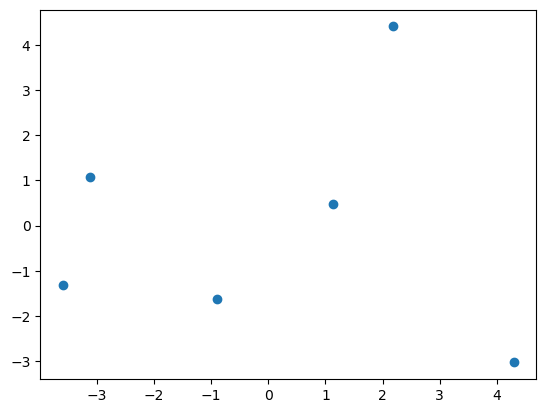

In [53]:
visualize_latent_space(latents)

In [41]:
import numpy as np

def visualize_latent_space_distribution(latent_primitives):
    # Reshape the latent primitives to be 2D
    latent_primitives = latent_primitives.reshape(-1, latent_primitives.shape[-1])

    # Perform PCA on the latent primitives
    pca = PCA(n_components=2)
    reduced_latents = pca.fit_transform(latent_primitives)

    # Create a 2D histogram
    heatmap, xedges, yedges = np.histogram2d(reduced_latents[:, 0], reduced_latents[:, 1], bins=50)
    
    # Plot the 2D histogram
    plt.imshow(heatmap.T, origin='lower')
    plt.show()


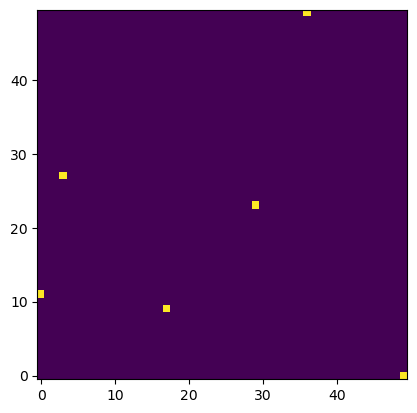

In [54]:
visualize_latent_space_distribution(latents)

In [43]:
from sklearn.manifold import TSNE

def plot_tsne(latent_primitives):
    # Flatten the batch and sequence dimension
    latent_primitives_flattened = latent_primitives.reshape(-1, latent_primitives.shape[-1])

    # Apply t-SNE
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(latent_primitives_flattened)

    # Plot
    plt.figure(figsize=(8, 8))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
    plt.show()


In [55]:
dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
batch = next(iter(dataloader))
poses, timestamps = batch["poses"], batch["timestamps"]
poses.shape, timestamps.shape

(torch.Size([64, 128, 3]), torch.Size([64, 128]))

In [56]:
out = model.encoder(poses=poses, timestamps=timestamps)
latent_primitives = out["latent_primitives"].detach().numpy()

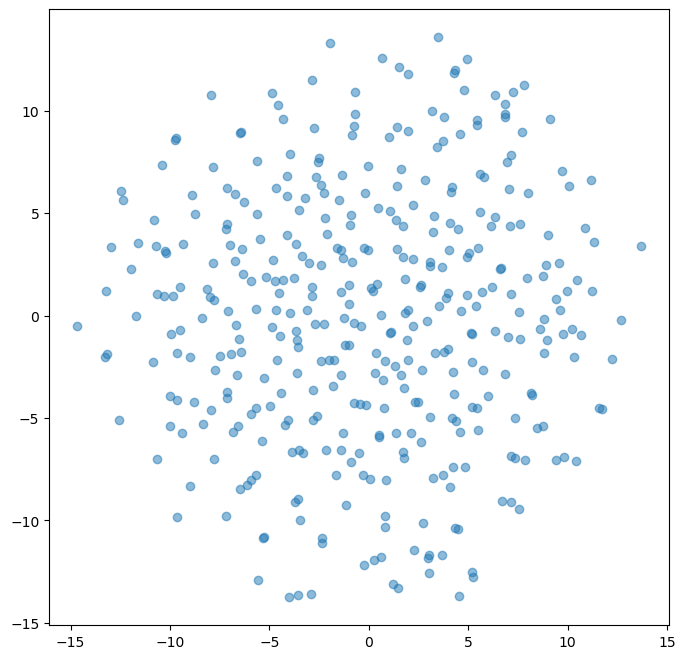

In [57]:
plot_tsne(latent_primitives)